В качестве итоговой аттестационной работы разработан **телеграм-бот** «Помощник менеджера культуры» (@nurengoy_culture_bot). Основная цель работы бота - классификация пользователей для предложения актуальных культурно-досуговых мероприятий.

Методы реализации проекта описаны согласно методологии CRISP DM.

# Этап 1. Понимание проблемы
Многие методы рекламного продвижения в учреждениях культуры зачастую оказываются нерабочими. Основной проблемой выступает отсутствие прямого контакта с пользователями, отсутствие электронной базы данных и их классификации (хотя бы по возрастному признаку).

Кроме непосредственной помощи работникам культурно-досугового сектора, бот также может стать интересной "фишкой" для наших потенциальных зрителей. Кому будет неинтересно узнать, куда в нашем маленьком городе посоветует сходить искусственный интеллект?

# Этап 2. Сбор данных
В связи с последними событиями актуальной площадкой для работы с людьми стала социальная сеть ВК.
Для получения необходимых данных был использован парсинг через API ВКонтакте.

In [ ]:
!pip install vk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


Соберем информацию о пользователях самой крупной по количеству участников группы города Новый Уренгой: [ГОРОРО](https://vk.com/nurengoy).

Поскольку у Нового Уренгоя небольшое население, такая цифра участников видится вполне реалистичной для дальнейшей работы.

In [ ]:
import vk  

def get_members(groupid):  # функция для сбора данных об участниках сообщества вк
  first = vk_api.groups.getMembers(group_id=groupid, fields='bdate, can_write_private_message, city, contacts, country, education, relation, sex, universities', v=5.131)
  data = first["items"]
  count = first["count"] // 1000 # API ограничивает парсинг до 1000 id, а нам понадобится гораздо больше
    
  for i in range(1, count+1):  
    data = data + vk_api.groups.getMembers(group_id=groupid, fields='bdate, city, country, education, relation, sex, universities', v=5.131, offset=i*1000)["items"]
  return data

if __name__ == "__main__": 
  vk_api = vk.API(access_token='тут был мой токен')
  group_members = get_members("nurengoy")

  print(len(group_members))


66624


Мы смогли собрать данные 66 624 аккаунтов. Это будет исходный рабочий сет данных, который подвергнется дальнейшей обработке. Помимо этого, соберем информацию из групп учреждений культуры.

Для понимания пересечения аудитории группы ГОРОРО с целевой аудиторией были выделены группы культурной сферы для города Новый Уренгой: 
- группа нашего учреждения [ГДК "Октябрь"](https://vk.com/gdk_oktyabr);
- группа [КСЦ "Газодобытчик"](https://vk.com/ksc_gazodobytchik) (второе крупное учреждение культуры в городе);
- группа [АРТ-резиденции](https://vk.com/art_residence_nur) города Новый Уренгой (молодежная политика);
- группа [ДС "Звездный"](https://vk.com/dszvezdnyi) (крупная спортивно-досуговая площадка города).

In [ ]:
if __name__ == "__main__": 
  vk_api = vk.API(access_token='тут был мой токен')
  gdk_members = get_members("gdk_oktyabr")

In [ ]:
if __name__ == "__main__": 
  vk_api = vk.API(access_token='тут был мой токен')
  ksc_members = get_members("ksc_gazodobytchik")

In [ ]:
if __name__ == "__main__": 
  vk_api = vk.API(access_token='тут был мой токен')
  art_members = get_members("art_residence_nur")

In [ ]:
if __name__ == "__main__": 
  vk_api = vk.API(access_token='тут был мой токен')
  zvezd_members = get_members("dszvezdnyi")

In [ ]:
# с этими данными мы поработаем позднее, а пока необходимо обработать исходный датасет
print(len(gdk_members))
print(len(ksc_members))
print(len(art_members))
print(len(zvezd_members))

6278
7763
8613
3403


# Этап 3. Обработка данных
В первую очередь, для удобства, соберем полученные данные в датафрейм. Так мы сможем увидеть, в каком виде к нам пришли собранные данные, и что необходимо сделать, чтобы привести их в надлежащий вид.

In [ ]:
import pandas as pd 
df_members = pd.DataFrame(group_members, columns =['id', 'bdate', 'city', 'country', 'can_write_private_message', 'sex', 'first_name', 'last_name', 'can_access_closed', 'is_closed'])
df_members.head()

,id,bdate,city,country,can_write_private_message,sex,first_name,last_name,can_access_closed,is_closed
0,4371,24.5.1988,"{'id': 2, 'title': 'Saint Petersburg'}","{'id': 1, 'title': 'Russia'}",1.0,2,Roman,Cherednichenko,True,False
1,4886,7.3,"{'id': 2, 'title': 'Saint Petersburg'}","{'id': 1, 'title': 'Russia'}",1.0,1,Zhannet,Venzhega,True,False
2,5318,28.9.1988,"{'id': 20950, 'title': 'Novy Urengoy'}","{'id': 1, 'title': 'Russia'}",1.0,2,Alexander,Norka,True,False
3,6697,NaN,"{'id': 2, 'title': 'Saint Petersburg'}","{'id': 1, 'title': 'Russia'}",1.0,2,Rash,Ka,True,False
4,8054,10.1.1988,"{'id': 2, 'title': 'Saint Petersburg'}","{'id': 1, 'title': 'Russia'}",1.0,1,Tamara,Pavlovskaya,True,False


In [ ]:
# посмотрим, в каком процентом соотношении присутствуют пропуски данных 

import numpy as np

for col in df_members.columns:
  pct_missing = np.mean(df_members[col].isnull())
  print('{} - {}%'.format(col, round(pct_missing*100)))    

id - 0%
bdate - 27%
city - 32%
country - 22%
can_write_private_message - 99%
sex - 0%
first_name - 0%
last_name - 0%
can_access_closed - 0%
is_closed - 0%


In [ ]:
# возьмем столбцы и интересующей нас информацией
# этой айди пользователя, дата рождения, город, страна, пол, закрытый/открытый профиль

df_members = df_members[['id', 'bdate', 'city', 'country', 'sex', 'is_closed']]
df_members.head()

,id,bdate,city,country,sex,is_closed
0,4371,24.5.1988,"{'id': 2, 'title': 'Saint Petersburg'}","{'id': 1, 'title': 'Russia'}",2,False
1,4886,7.3,"{'id': 2, 'title': 'Saint Petersburg'}","{'id': 1, 'title': 'Russia'}",1,False
2,5318,28.9.1988,"{'id': 20950, 'title': 'Novy Urengoy'}","{'id': 1, 'title': 'Russia'}",2,False
3,6697,NaN,"{'id': 2, 'title': 'Saint Petersburg'}","{'id': 1, 'title': 'Russia'}",2,False
4,8054,10.1.1988,"{'id': 2, 'title': 'Saint Petersburg'}","{'id': 1, 'title': 'Russia'}",1,False


In [ ]:
# заполним пропуски по городам значением id города Новый Уренгой

df_members['city'] = df_members['city']. fillna (20950)

In [ ]:
# заполним пропуски по странам значением id России

df_members['country'] = df_members['country']. fillna (1)

In [ ]:
df_members = df_members.dropna() # мы потеряли часть информации, однако, предстоит потерять еще
#поскольку столбец с датами рождения заполнен не совсем корректно, есть отсутствующая информации о годе рождения

In [ ]:
# обработаем записи в столбцах, поскольку сейчас они в виде словарей
# возьмем из исходных словарей значения id, поскольку они числовые

cities = list(df_members['city'])
clean_cities = []

for i in cities:
  try:
    clean_cities.append(i.get('id'))
  except AttributeError: # используем try-exept, ведь на предыдущем шаге мы заменили пропуски на числа
    clean_cities.append(i)

In [ ]:
# сделаем то же для стран

countries = list(df_members['country'])
clean_countries = []

for i in countries:
  try:
    clean_countries.append(i.get('id'))
  except AttributeError:
    clean_countries.append(i)

In [ ]:
df_members['city'] = clean_cities
df_members['country'] = clean_countries
df_members.head()

,id,bdate,city,country,sex,is_closed
0,4371,24.5.1988,2,1,2,False
1,4886,7.3,2,1,1,False
2,5318,28.9.1988,20950,1,2,False
4,8054,10.1.1988,2,1,1,False
5,8612,1.4.1996,1803702,191,1,False


In [ ]:
# теперь разберемся с датами рождения
# в некоторых строках год рождения отсуствует, и мы не сможем предугадать его с точностью
# поэтому проще будет избавиться от этих данных 

birth = list(df_members['bdate'])
nan_birth = []

for i in birth:
  if len(i) > 5:
    nan_birth.append(i)
  else:
    f = float('NaN')
    nan_birth.append(f)

In [ ]:
import datetime
from datetime import date

df_members['bdate'] = nan_birth
df_members = df_members.dropna()

In [ ]:
# добавим столбец с возрастом пользователей

df_members['bdate'] = pd.to_datetime(df_members['bdate'], format="%d.%m.%Y", errors='coerce')

df_members['age'] = df_members['bdate'].apply(lambda x : (pd.datetime.now().year - x.year))

In [ ]:
# посмотрим на наши данные теперь

for col in df_members.columns:
  pct_missing = np.mean(df_members[col].isnull())
  print('{} - {}%'.format(col, round(pct_missing*100)))  

id - 0%
bdate - 0%
city - 0%
country - 0%
sex - 0%
is_closed - 0%
age - 0%


In [ ]:
# также столбец is_closed нужно привести к целочисленному формату:

closed = list(df_members['is_closed'])
closed_num = []

for i in closed:
  if i:
    closed_num.append(1)
  else:
    closed_num.append(0)

df_members['is_closed'] = closed_num

In [ ]:
df_members = df_members.drop_duplicates() # почистим дф от возможных дубликатов
df_members.shape

(31564, 7)

In [ ]:
# посмотрим, какой результат получился после очистки
df_members.head()

,id,bdate,city,country,sex,is_closed,age
0,4371,1988-05-24,2,1,2,0,34
2,5318,1988-09-28,20950,1,2,0,34
4,8054,1988-01-10,2,1,1,0,34
5,8612,1996-04-01,1803702,191,1,0,26
15,18329,1987-11-10,20950,1,1,1,35


В результате обработки получился датафрейм, содержащий уникальные id пользователей, id городов и стран, информацию о поле (0 - не указан, 1 - мужчина, 2 - женщина), информацию о профиле (0 - открытый, 1 - закрытый), возраст пользователя.

Благодаря пошаговой обработке исходного датафрейма мы сможем обработать данные, полученные из целевых групп, написав соответствующую функцию.

In [ ]:
def dataframe_cleaner(members):
  df = pd.DataFrame(members, columns =['id', 'bdate', 'city', 'country', 'can_write_private_message', 'sex', 'first_name', 'last_name', 'can_access_closed', 'is_closed'])
  df = df[['id', 'bdate', 'city', 'country', 'sex', 'is_closed']]
  df['city'] = df['city'].fillna(20950) 
  df['country'] = df['country'].fillna(1)
  df = df.dropna()

  old_cities = list(df['city'])
  new_cities = []

  old_countries = list(df['country'])
  new_countries = []
  
  for i in old_cities:
    try:
      new_cities.append(i.get('id'))
    except AttributeError:
      new_cities.append(i)
  
  df['city'] = new_cities

  for j in old_countries:
    try:
      new_countries.append(j.get('id'))
    except AttributeError:
      new_countries.append(j)
      
  df['country'] = new_countries

  old_birth = list(df['bdate'])
  nan2_birth = []

  for a in old_birth:
    if len(a) > 5:
      nan2_birth.append(a)
    else:
      fl = float('NaN')
      nan2_birth.append(fl)

  df['bdate'] = nan2_birth
  df = df.dropna()

  df['bdate'] = pd.to_datetime(df['bdate'], format="%d.%m.%Y", errors='coerce')
  df['age'] = df['bdate'].apply(lambda x : (pd.datetime.now().year - x.year))

  closed2 = list(df['is_closed'])
  closed2_num = []
  
  for b in closed2:
    if b:
      closed2_num.append(1)
    else:
      closed2_num.append(0)

  df['is_closed'] = closed2_num
  df = df.drop_duplicates() 
  
  return df

In [ ]:
df_gdk = dataframe_cleaner(gdk_members)
df_gdk.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


,id,bdate,city,country,sex,is_closed,age
0,5318,1988-09-28,20950,1,2,0,34
2,41220,1988-11-14,20950,1,1,0,34
5,79928,1986-03-05,2,1,2,0,36
6,80683,1977-05-02,1,1,2,0,45
7,80701,2006-08-01,2,1,1,0,16



Теперь мы внесем еще несколько характеристик: 
- **Приоритетность** (от 0 до 8). Она будет означать, в какую группу попадает аккаунт.
- Маркер, состоит ли пользователь в группе: 0 - да, 1 - нет

In [ ]:
df_gdk['priority'] = float('NaN')
df_gdk['marker'] = 0
df_gdk.head()

,id,bdate,city,country,sex,is_closed,age,priority,marker
0,5318,1988-09-28,20950,1,2,0,34,NaN,0
2,41220,1988-11-14,20950,1,1,0,34,NaN,0
5,79928,1986-03-05,2,1,2,0,36,NaN,0
6,80683,1977-05-02,1,1,2,0,45,NaN,0
7,80701,2006-08-01,2,1,1,0,16,NaN,0


In [ ]:
# в этот df попали id участников группы КСЦ "Газодобытчик"

df_ksc = dataframe_cleaner(ksc_members)
df_ksc['priority'] = float('NaN')
df_ksc['marker_ksc'] = 0
df_ksc.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


,id,bdate,city,country,sex,is_closed,age,priority,marker_ksc
1,41220,1988-11-14,20950,1,1,0,34,NaN,0
4,79928,1986-03-05,2,1,2,0,36,NaN,0
12,199133,1988-10-21,20950,1,1,1,34,NaN,0
16,257698,1988-09-17,20950,1,1,1,34,NaN,0
17,296587,1969-01-23,20950,1,2,0,53,NaN,0


In [ ]:
# объединим получившиеся df
united1 = pd.merge(df_gdk, df_ksc, how='outer', on=['id', 'bdate', 'city', 'country', 'sex', 'is_closed', 'age', 'priority'])

united1['marker'] = united1['marker'].fillna(0)
united1 = united1[['id', 'bdate', 'city', 'country', 'sex', 'is_closed', 'age', 'priority', 'marker']]
united1 

,id,bdate,city,country,sex,is_closed,age,priority,marker
0,5318,1988-09-28,20950,1,2,0,34,NaN,0.0
1,41220,1988-11-14,20950,1,1,0,34,NaN,0.0
2,79928,1986-03-05,2,1,2,0,36,NaN,0.0
3,80683,1977-05-02,1,1,2,0,45,NaN,0.0
4,80701,2006-08-01,2,1,1,0,16,NaN,0.0
...,...,...,...,...,...,...,...,...,...
4572,753254590,1983-04-02,20950,1,2,1,39,NaN,0.0
4573,755628717,1973-05-05,20950,1,1,0,49,NaN,0.0
4574,756922296,1986-10-09,20950,1,1,0,36,NaN,0.0
4575,757709339,1982-10-02,20950,1,1,0,40,NaN,0.0


In [ ]:
# в этот df попали id участников группы учреждения АРТ-резиденция

df_art = dataframe_cleaner(art_members)
df_art['priority'] = float('NaN')
df_art['marker_art'] = 0
df_art.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


,id,bdate,city,country,sex,is_closed,age,priority,marker_art
0,5318,1988-09-28,20950,1,2,0,34,NaN,0
4,41220,1988-11-14,20950,1,1,0,34,NaN,0
7,79928,1986-03-05,2,1,2,0,36,NaN,0
11,114938,1989-01-24,20950,1,1,0,33,NaN,0
13,175468,1984-10-06,20950,1,2,1,38,NaN,0


In [ ]:
# объединим получившиеся df
united2 = pd.merge(united1, df_art, how='outer', on=['id', 'bdate', 'city', 'country', 'sex', 'is_closed', 'age', 'priority'])

united2['marker'] = united2['marker'].fillna(0)
united2 = united2[['id', 'bdate', 'city', 'country', 'sex', 'is_closed', 'age', 'priority', 'marker']]
united2 

,id,bdate,city,country,sex,is_closed,age,priority,marker
0,5318,1988-09-28,20950,1,2,0,34,NaN,0.0
1,41220,1988-11-14,20950,1,1,0,34,NaN,0.0
2,79928,1986-03-05,2,1,2,0,36,NaN,0.0
3,80683,1977-05-02,1,1,2,0,45,NaN,0.0
4,80701,2006-08-01,2,1,1,0,16,NaN,0.0
...,...,...,...,...,...,...,...,...,...
6792,744299349,1993-04-13,20950,1,2,0,29,NaN,0.0
6793,752018294,2008-09-23,20950,1,2,1,14,NaN,0.0
6794,755203587,1982-08-25,20950,1,2,0,40,NaN,0.0
6795,755222726,2006-06-16,20950,1,1,1,16,NaN,0.0


In [ ]:
# в этот df попали id участников группы учреждения Дворец спорта "Звездный"
df_zvezd = dataframe_cleaner(zvezd_members)
df_zvezd['priority'] = float('NaN')
df_zvezd['marker_zv'] = 0
df_zvezd.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.


,id,bdate,city,country,sex,is_closed,age,priority,marker_zv
0,5318,1988-09-28,20950,1,2,0,34,NaN,0
4,175468,1984-10-06,20950,1,2,1,38,NaN,0
7,243036,1989-09-30,20950,1,1,0,33,NaN,0
9,257698,1988-09-17,20950,1,1,1,34,NaN,0
13,330345,1989-01-13,20950,1,1,1,33,NaN,0


In [ ]:
# объединим получившиеся df
united3 = pd.merge(united2, df_zvezd, how='outer', on=['id', 'bdate', 'city', 'country', 'sex', 'is_closed', 'age', 'priority'])

united3['marker'] = united3['marker'].fillna(0)
united3 = united3[['id', 'bdate', 'city', 'country', 'sex', 'is_closed', 'age', 'priority', 'marker']]

united3

,id,bdate,city,country,sex,is_closed,age,priority,marker
0,5318,1988-09-28,20950,1,2,0,34,NaN,0.0
1,41220,1988-11-14,20950,1,1,0,34,NaN,0.0
2,79928,1986-03-05,2,1,2,0,36,NaN,0.0
3,80683,1977-05-02,1,1,2,0,45,NaN,0.0
4,80701,2006-08-01,2,1,1,0,16,NaN,0.0
...,...,...,...,...,...,...,...,...,...
7466,754292643,2003-08-01,20950,1,2,1,19,NaN,0.0
7467,755922637,2002-04-16,20950,1,2,0,20,NaN,0.0
7468,758135994,2008-06-10,20950,1,2,0,14,NaN,0.0
7469,760084478,1977-03-28,20950,1,2,0,45,NaN,0.0


In [ ]:
# теперь соберем эти данные и данные из исходного датафрейма

newDF = pd.merge(united3, df_members, how='outer', on=['id', 'bdate', 'city', 'country', 'sex', 'is_closed', 'age']) 
newDF['marker'] = newDF['marker'].fillna(1)

for col in newDF.columns:
  pct_missing = np.mean(newDF[col].isnull())
  print('{} - {}%'.format(col, round(pct_missing*100))) 

newDF

id - 0%
bdate - 0%
city - 0%
country - 0%
sex - 0%
is_closed - 0%
age - 0%
priority - 100%
marker - 0%


,id,bdate,city,country,sex,is_closed,age,priority,marker
0,5318,1988-09-28,20950,1,2,0,34,NaN,0.0
1,41220,1988-11-14,20950,1,1,0,34,NaN,0.0
2,79928,1986-03-05,2,1,2,0,36,NaN,0.0
3,80683,1977-05-02,1,1,2,0,45,NaN,0.0
4,80701,2006-08-01,2,1,1,0,16,NaN,0.0
...,...,...,...,...,...,...,...,...,...
33965,763700076,1989-05-05,20950,1,2,0,33,NaN,1.0
33966,763731149,1992-01-05,20950,1,2,1,30,NaN,1.0
33967,763749349,1988-07-14,20950,1,1,0,34,NaN,1.0
33968,763908255,1979-11-19,20950,1,2,0,43,NaN,1.0


In [ ]:
# заполним группы приоритетности

# 0 - детская аудитория, подписаны на группы
kids = (newDF['age'] <= 13) & (newDF['is_closed'] == 0) & (newDF['marker'] == 0)

# 1 - пушкинская карта + молодые люди, подписаны на группы
pushka = (newDF['age'] >= 14) & (newDF['age'] <= 30) & (newDF['is_closed'] == 0) & (newDF['marker'] == 0)

# 2 - взрослые до 60 лет, подписаны на группы
adult = (newDF['age'] >= 31) & (newDF['age'] <= 59) & (newDF['is_closed'] == 0) & (newDF['marker'] == 0)

# 3 - старшее поколение от 60 лет, подписаны на группы
elderly = (newDF['age'] >= 60) & (newDF['is_closed'] == 0) & (newDF['marker'] == 0)

# 4 - детская аудитория, не подписаны на группы
kids_subs = (newDF['age'] <= 13) & (newDF['is_closed'] == 0) & (newDF['marker'] == 1)

# 5 - пушкинская карта + молодые люди, не подписаны на группы
pushka_subs = (newDF['age'] >= 14) & (newDF['age'] <= 30) & (newDF['is_closed'] == 0) & (newDF['marker'] == 1)

# 6 - взрослые до 60 лет, не подписаны на группы
adult_subs = (newDF['age'] >= 31) & (newDF['age'] <= 59) & (newDF['is_closed'] == 0) & (newDF['marker'] == 1)

# 7 - старшее поколение от 60 лет, подписаны на группы
elderly_subs = (newDF['age'] >= 60) & (newDF['is_closed'] == 0) & (newDF['marker'] == 1)

newDF.loc[kids, 'priority'] = newDF.loc[kids, 'priority'].fillna(0)
newDF.loc[pushka, 'priority'] = newDF.loc[pushka, 'priority'].fillna(1)
newDF.loc[adult, 'priority'] = newDF.loc[adult, 'priority'].fillna(2)
newDF.loc[elderly, 'priority'] = newDF.loc[elderly, 'priority'].fillna(3)

newDF.loc[kids_subs, 'priority'] = newDF.loc[kids_subs, 'priority'].fillna(4)
newDF.loc[pushka_subs, 'priority'] = newDF.loc[pushka_subs, 'priority'].fillna(5)
newDF.loc[adult_subs, 'priority'] = newDF.loc[adult_subs, 'priority'].fillna(6)
newDF.loc[elderly_subs, 'priority'] = newDF.loc[elderly_subs, 'priority'].fillna(7)

In [ ]:
# пользователей, которые не попали под условия выше, заполняем другим значением приоритета
newDF['priority'] = newDF['priority'].fillna(8)

for col in newDF.columns:
  pct_missing = np.mean(newDF[col].isnull())
  print('{} - {}%'.format(col, round(pct_missing*100)))  

id - 0%
bdate - 0%
city - 0%
country - 0%
sex - 0%
is_closed - 0%
age - 0%
priority - 0%
marker - 0%


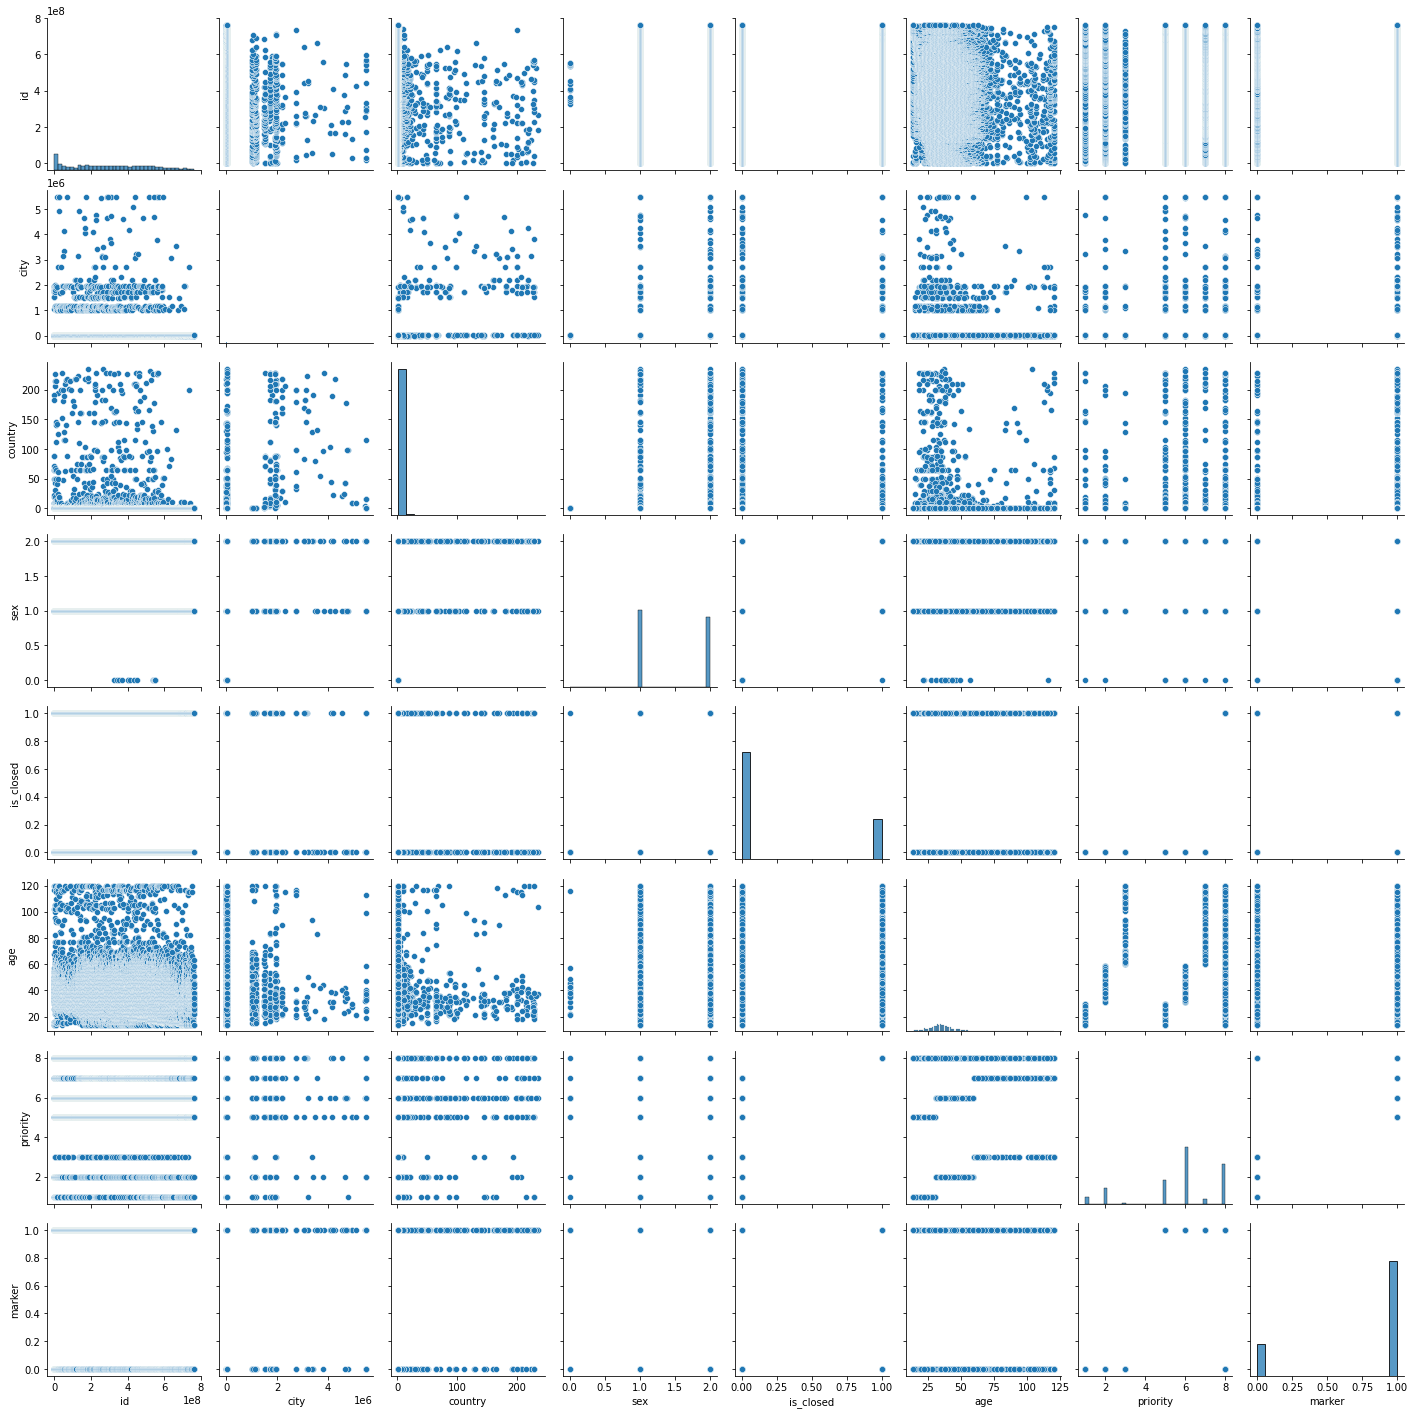

In [ ]:
# визуализируем графики пар количественных признаков

import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(newDF)

In [ ]:
# посмотрим на корреляционную матрицу

corelation_matrix = newDF.corr()
corelation_matrix.style.background_gradient(axis=0)  

,id,city,country,sex,is_closed,age,priority,marker
id,1.000000,-0.008564,-0.013217,-0.013310,-0.057446,-0.013946,-0.005689,0.085096
city,-0.008564,1.000000,0.445144,0.033062,-0.002302,0.023113,0.008495,0.014097
country,-0.013217,0.445144,1.000000,0.029051,-0.001021,0.027342,0.005178,0.012538
sex,-0.013310,0.033062,0.029051,1.000000,-0.035505,-0.021886,0.072316,0.179377
is_closed,-0.057446,-0.002302,-0.001021,-0.035505,1.000000,-0.056883,0.680930,-0.047533
age,-0.013946,0.023113,0.027342,-0.021886,-0.056883,1.000000,0.136344,0.032331
priority,-0.005689,0.008495,0.005178,0.072316,0.680930,0.136344,1.000000,0.550900
marker,0.085096,0.014097,0.012538,0.179377,-0.047533,0.032331,0.550900,1.000000


In [ ]:
# сохраним наш датафрейм в csv

newDF.to_csv("culture_information.csv", index=False)

Промежуточный вывод: обработка датафрейма и введение характеристики приоритета и маркеры пользователей по группам помогли нам добиться некоторых результатов.
Видна корреляция групп с открытостью профиля, присутствует небольшая корреляция по возрасту. Также есть корреляция по маркерам.

Данные размечены. Интересующая характеристика (приоритетность) носит дискретный характер. Соответственно, необходимо реализовать классификацию данных.

# Этап 4. Реализация машинного обучения
Полученный датафрейм будет обработан через машинное обучение с учителем (классификация).

Воспользуемся деревом решений, методом опорных векторов и методом к-ближайших соседей.

In [ ]:
import pandas as pd
import numpy as np

machine_learning = pd.read_csv('culture_information.csv')
machine_learning.head()

,id,bdate,city,country,sex,is_closed,age,priority,marker
0,5318,1988-09-28,20950,1,2,0,34,2.0,0.0
1,41220,1988-11-14,20950,1,1,0,34,2.0,0.0
2,79928,1986-03-05,2,1,2,0,36,2.0,0.0
3,80683,1977-05-02,1,1,2,0,45,2.0,0.0
4,80701,2006-08-01,2,1,1,0,16,1.0,0.0


In [ ]:
x_data = machine_learning[['is_closed', 'age', 'marker']] 
# по сути, мы выбираем только главные компоненты, которые имеют значение при выбранных категориях приоритета пользователей

y_data = list(machine_learning['priority'])

In [ ]:
# разделим данные на тренировочную и тестовую выборки в соотношении 80% и 20%

from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

In [ ]:
# 1. Дерево решений

from sklearn.tree import DecisionTreeClassifier 

tree_model = DecisionTreeClassifier()
tree_model.fit(x_train, y_train)

DecisionTreeClassifier()

In [ ]:
tree_pred = tree_model.predict(x_test)
print(tree_pred[1], y_test[1])

6.0 6.0


In [ ]:
# 2. Метод к-ближайших соседей

from sklearn.neighbors import KNeighborsClassifier

# выберем оптимальное количество соседей
errors = []

for i in range(1, 10):
  neighbours_model = KNeighborsClassifier(n_neighbors=i)
  neighbours_model.fit(x_train, y_train)
  pred_i = neighbours_model.predict(x_test)
  errors.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Средняя ошибка')

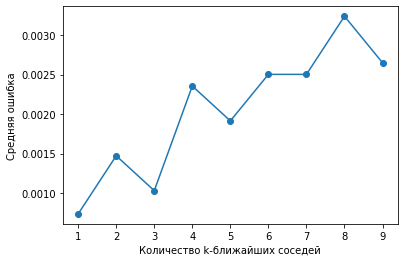

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, 10), errors, marker='o')
plt.xlabel('Количество k-ближайших соседей')
plt.ylabel('Средняя ошибка')

In [ ]:
# лучшее значение ошибки - при 1 и 3. выберем 3

neighbours_model = KNeighborsClassifier(n_neighbors=3)
neighbours_model.fit(x_train, y_train)

neighbours_pred = neighbours_model.predict(x_test)
print(neighbours_pred[6], y_test[6])

2.0 2.0


In [ ]:
# 3. Метод опорных векторов

from sklearn.svm import SVC
vector_model = SVC(kernel='linear')
vector_model.fit(x_train, y_train)

SVC(kernel='linear')

In [ ]:
vector_pred = vector_model.predict(x_test)
print(vector_pred[2], y_test[2])

8.0 8.0


# Этап 5. Оценка моделей классификации
Для оценки использованных моделей используем следующие метрики:
- доля правильных ответов;
- точность;
- полнота;
- F-мера.

Рассмотрим цельные матрицы ошибок по каждой из моделей.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def metrics (y_true, y_pred):
  accuracy = accuracy_score(y_pred, y_true)
  print("Доля правильных ответов равна: ", accuracy)

  precision = precision_score(y_true, y_pred, average='macro')
  print("Точность равна: ", precision)

  recall = recall_score(y_true, y_pred, average='macro')
  print("Полнота равна: ", recall)

  fscore = 2 * (recall * precision) / (recall + precision)
  print("F-мера равна: ", fscore)
  return

In [ ]:
# для модели Дерева решений

print(metrics(y_test, tree_pred))

Доля правильных ответов равна:  1.0
Точность равна:  1.0
Полнота равна:  1.0
F-мера равна:  1.0
None


In [ ]:
print(confusion_matrix(y_test, tree_pred))

tree_report = classification_report(y_test, tree_pred)
print(tree_report)

[[ 282    0    0    0    0    0    0]
 [   0  721    0    0    0    0    0]
 [   0    0   32    0    0    0    0]
 [   0    0    0 1029    0    0    0]
 [   0    0    0    0 2699    0    0]
 [   0    0    0    0    0  179    0]
 [   0    0    0    0    0    0 1852]]
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       282
         2.0       1.00      1.00      1.00       721
         3.0       1.00      1.00      1.00        32
         5.0       1.00      1.00      1.00      1029
         6.0       1.00      1.00      1.00      2699
         7.0       1.00      1.00      1.00       179
         8.0       1.00      1.00      1.00      1852

    accuracy                           1.00      6794
   macro avg       1.00      1.00      1.00      6794
weighted avg       1.00      1.00      1.00      6794



In [ ]:
# для модели k-ближайших соседей

print(metrics(y_test, neighbours_pred))

Доля правильных ответов равна:  0.9989696791286429
Точность равна:  0.9907585004359198
Полнота равна:  0.9906857451403888
F-мера равна:  0.9907221214524283
None


In [ ]:
print(confusion_matrix(y_test, neighbours_pred))
neighbour_report = classification_report(y_test, neighbours_pred)
print(neighbour_report)

[[ 282    0    0    0    0    0    0]
 [   0  721    0    0    0    0    0]
 [   0    0   30    0    0    2    0]
 [   0    0    0 1029    0    0    0]
 [   0    0    0    0 2699    0    0]
 [   0    0    0    0    0  179    0]
 [   0    0    1    0    0    4 1847]]
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       282
         2.0       1.00      1.00      1.00       721
         3.0       0.97      0.94      0.95        32
         5.0       1.00      1.00      1.00      1029
         6.0       1.00      1.00      1.00      2699
         7.0       0.97      1.00      0.98       179
         8.0       1.00      1.00      1.00      1852

    accuracy                           1.00      6794
   macro avg       0.99      0.99      0.99      6794
weighted avg       1.00      1.00      1.00      6794



In [ ]:
# для метода опорных векторов

print(metrics(y_test, vector_pred))

Доля правильных ответов равна:  1.0
Точность равна:  1.0
Полнота равна:  1.0
F-мера равна:  1.0
None


In [ ]:
print(confusion_matrix(y_test, vector_pred))

vector_report = classification_report(y_test, vector_pred)
print(vector_report)

[[ 282    0    0    0    0    0    0]
 [   0  721    0    0    0    0    0]
 [   0    0   32    0    0    0    0]
 [   0    0    0 1029    0    0    0]
 [   0    0    0    0 2699    0    0]
 [   0    0    0    0    0  179    0]
 [   0    0    0    0    0    0 1852]]
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       282
         2.0       1.00      1.00      1.00       721
         3.0       1.00      1.00      1.00        32
         5.0       1.00      1.00      1.00      1029
         6.0       1.00      1.00      1.00      2699
         7.0       1.00      1.00      1.00       179
         8.0       1.00      1.00      1.00      1852

    accuracy                           1.00      6794
   macro avg       1.00      1.00      1.00      6794
weighted avg       1.00      1.00      1.00      6794



Метод **k-ближайших соседей** показывает хорошие результаты: 99%. С выборкой по категориям 3 и 7 справляется немного хуже, но полагаю, это связано с тем, что в нее попало недостаточно аккаунтов

**Дерево решений** и метод **опорных векторов** показывают превосходные 100%-ные результаты.

В целом, можно выбрать любую из обученных моделей - все они справляются с поставленной задачей.

In [ ]:
# сохраним обученные модели

import pickle

pkl_tree_filename = "tree_model.pkl"
with open(pkl_tree_filename, 'wb') as file:
    pickle.dump(tree_model, file)

In [ ]:
pkl_vector_filename = "vector_model.pkl"
with open(pkl_vector_filename, 'wb') as file:
    pickle.dump(vector_model, file)

In [ ]:
pkl_neighbours_filename = "neighbours_model.pkl"
with open(pkl_neighbours_filename, 'wb') as file:
    pickle.dump(neighbours_model, file)

Для дальнейшего развертывания воспользуемся моделью **Дерева решений**.

# Этап 6. Развертывание проекта
В качестве развертывания создан телеграм-бот: помощник менеджера культуры.

In [ ]:
!pip install pyTelegramBotAPI

In [ ]:
# бот будет получать ссылку на страницу от пользователя
# напишем функцию, которая ищет ссылку в сообщении
import re

def get_link(message_text):
    link_arr = re.findall(r'^https?:\/\/?[\w-]{1,32}'
                          r'\.[\w-]{1,32}[^\s@]*$', message_text)
    if len(link_arr) > 0:
        link = str(link_arr[0])
        slash_id = link[14:]
        if '/id' in slash_id: # если это оригинальный id с цифрами 
          id = link[17:]
          return id
        else: # если id пользователя состоит из букв
          id = link[15:]
          return id
    return False

In [ ]:
# полученный из сообщения id отправится в другую функцию
# через API Вк мы получим интересующую нас информацию для работы с моделью машинного обучения

import vk 
import numpy as np
import pandas as pd

vk_api = vk.API(access_token='тут был мой токен')

def get_user_infromation(id): 
  check = vk_api.users.get(user_ids=id, fields='bdate, city, country, sex', v=5.131) # получаем информацию о пользователе
  return check

In [ ]:
all_ids = list(machine_learning['id']) # соберем в список все айдишники, которые мы собрали ранее

def get_df_info(check): 
  for i in check:
    original_id = i.get('id')

  df = dataframe_cleaner(check) # воспользуемся уже написанной ранее функцией по очистке информации для дф
  if df.shape == (0,7): # если в профиле отсутствует нужная инфа, нам вернется пустой дф
    oops = "Ой, что-то сломалось 😫 Кажется, у нас недостаточно информации. Поищи другой профиль."
    return oops

  else:

    if original_id in all_ids: # проверяем, есть ли id в нашем большом датасете
      
      idx = int(machine_learning[machine_learning['id'] == original_id].index.values) # если есть, мы дублируем маркер оттуда
      marker = float(machine_learning.loc[idx, ['marker']])
      df['marker'] = marker

    else:
      df['marker'] = 4.0 # если нет, ставим маркер 4
    
    x_data = df[['is_closed', 'age', 'marker']]
    return x_data

In [ ]:
def learning_func (dataframe): # функция для обработки предсказания 
  with open(pkl_tree_filename, 'rb') as file: # импортируем модель из файла
    pickle_model = pickle.load(file)

  prediction = pickle_model.predict(dataframe)
  prediction_num = int(prediction)

  return prediction_num

In [ ]:
import telebot

tg_token = "тут был мой токен"
bot = telebot.TeleBot(tg_token)

# cоберем нашего бота
# он будет здороваться и рассказывать о том, что может сделать 

@bot.message_handler(commands=['start', 'help'])

def say_hello(message):
  bot.reply_to(message, 'Привет 👋 Я - помощник менеджера культуры для города Новый Уренгой.')
  bot.send_message(message.from_user.id, 'Ты можешь отправить мне ссылку на пользователя Вконтакте, и я посоветую, какое мероприятие ему предложить.')
  bot.send_message(message.from_user.id, 'Помни, что пользователь должен быть жителем Нового Уренгоя 😉😉 Иначе зачем мы будем работать с ним?')
  
@bot.message_handler(content_types=['text'])

def any_message(message):
  link = get_link(message.text)
  if link: # бот ищет в тексте сообщения ссылку
    bot.send_message(message.from_user.id, "Да, я вижу ссылку ✌🏻 Давай посмотрим, что можно предложить этому человеку.")
    info = get_user_infromation(link) # обрабатываем ссылку через функцию, получаем информацию
    get_df = get_df_info(info) # обрабатываем информацию

    if type(get_df) == str:  # если функция вернула строку, обработка не удалась
      bot.send_message(message.from_user.id, get_df)
      bot.send_message(message.from_user.id, "Напоминаю, что нужно для успешной работы со зрителем:")
      bot.send_message(message.from_user.id, "⭐️ это житель НУРа;\n⭐️ в профиле указана дата рождения с годом (нам нужно выяснить возраст)")
    
    else: # функция вернула дф
      result_model_tree = learning_func(get_df) # в переменную result мы получаем предсказание от 0 до 8 (это наша приоритетность)
      
      # в зависимости от приоритета бот предлагает разные мероприятия (на момент проверки некоторые из них могут уже пройти :))
      
      if result_model_tree == 0:
        bot.send_message(message.from_user.id, "Этот аккаунт является подписчиком групп учреждений культуры! 🤩🤩")
        bot.send_message(message.from_user.id, "Я очень люблю мероприятия для детской аудитории. Вот, например...")
        bot.send_message(message.from_user.id, 'https://гдкоктябрьнур.рф/wp-content/uploads/2022/09/600h800-czirk.jpg')
      
      elif result_model_tree == 1:
        bot.send_message(message.from_user.id, "Этот аккаунт является подписчиком групп учреждений культуры! 🤩🤩")
        bot.send_message(message.from_user.id, "Судя по возрасту, ему/ей можно предложить что-нибудь крутое по Пушкинской карте.\nКстати, совершенно бесплатно 👍🏻")
        bot.send_message(message.from_user.id, 'https://гдкоктябрьнур.рф/wp-content/uploads/2020/08/hanuma-dekabr.jpg')

      elif result_model_tree == 2:
        bot.send_message(message.from_user.id, "Этот аккаунт является подписчиком групп учреждений культуры! 🤩🤩")
        bot.send_message(message.from_user.id, "Посмотрим, что я могу предложить для взрослой аудитории...")
        bot.send_message(message.from_user.id, "https://гдкоктябрьнур.рф/wp-content/uploads/2020/08/150x200-banner-ohota.jpg")

      elif result_model_tree == 3:
        bot.send_message(message.from_user.id, "Этот аккаунт является подписчиком групп учреждений культуры! 🤩🤩")
        bot.send_message(message.from_user.id, "Для старшего поколения у меня есть отличный вариант! Вот, взгляни...")
        bot.send_message(message.from_user.id, "https://гдкоктябрьнур.рф/wp-content/uploads/2020/08/den-materi.jpg")

      elif result_model_tree == 4:
        bot.send_message(message.from_user.id, "Как жаль, что этот аккаунт не подписан на нас 😞 Надо это исправить!")
        bot.send_message(message.from_user.id, "Я очень люблю мероприятия для детской аудитории. Вот, например...")
        bot.send_message(message.from_user.id, 'https://гдкоктябрьнур.рф/wp-content/uploads/2022/09/600h800-czirk.jpg')
      
      elif result_model_tree == 5:
        bot.send_message(message.from_user.id, "Как жаль, что этот аккаунт не подписан на нас 😞 Надо это исправить!")
        bot.send_message(message.from_user.id, "Судя по возрасту, ему/ей можно предложить что-нибудь крутое по Пушкинской карте.\nКстати, совершенно бесплатно 👍🏻")
        bot.send_message(message.from_user.id, 'https://гдкоктябрьнур.рф/wp-content/uploads/2020/08/hanuma-dekabr.jpg')

      elif result_model_tree == 6:
        bot.send_message(message.from_user.id, "Как жаль, что этот аккаунт не подписан на нас 😞 Надо это исправить!")
        bot.send_message(message.from_user.id, "Посмотрим, что я могу предложить для взрослой аудитории...")
        bot.send_message(message.from_user.id, "https://гдкоктябрьнур.рф/wp-content/uploads/2020/08/150x200-banner-ohota.jpg")

      elif result_model_tree == 7:
        bot.send_message(message.from_user.id, "Как жаль, что этот аккаунт не подписан на нас 😞 Надо это исправить!")
        bot.send_message(message.from_user.id, "Для старшего поколения у меня есть отличный вариант! Вот, взгляни...")
        bot.send_message(message.from_user.id, "https://гдкоктябрьнур.рф/wp-content/uploads/2020/08/den-materi.jpg")

      elif result_model_tree == 7:
        bot.send_message(message.from_user.id, "Хм 🤔 Кажется, этот аккаунт не может быть проанализирован.")
      
  else: # бот не нашел ссылку
    bot.send_message(message.from_user.id, "Я не вижу ссылку на пользователя 👀 Попробуй еще раз.")

bot.infinity_polling()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a fut

Ссылка на ТГ-бота: https://t.me/nurengoy_culture_bot 

Конечно же, он не будет работать без токенов :)